<a href="https://colab.research.google.com/github/jihoonkim2100/ANPP/blob/master/ANPP_Final_Ver73.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
################################################################################
"""
This is a Programming Project for Affective, Social Neuroscience (SoSe 2020).
This module provides the predictive modeling for level of immersion based on
 valence and arousal using the dataset:
<https://box.fu-berlin.de/s/2bP2cdDaeefBy2n >

Those are requirement to run this module:
    - python
    - keras
    - matplotlib
    - numpy
    - pandas
    - seaborn
    - statsmodels
    - sklearn
    - google
    - xgboost

This modules consists of four main part:
    - PART I: Group and Data Selection
    - PART II: Data Preprocessing
    - PART III: Predictive Modeling
    - PART IV: Statistical Analysis with BIG FIVE

We are highly recommend to use the google colab using GPU.

Authors: Andreea Al-Afuni, JiHoon Kim, Angela Sofia Royo Romero, and Bati Yilmaz
Last-modified : 4th October 2020
"""

In [1]:
################################################################################# 0. Import the library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from google.colab import drive                                                  
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import Input
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import svm, linear_model, metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
sns.set(style="darkgrid", color_codes=True)
np.random.seed(20201005)                                                        # To ensure the reproducibility of the programm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
################################################################################ PART I: Group and Data Selection
                                                                                # 1. Load the dataset: SENT_GROUP_INFO and SENT_RATING_DATA
drive.mount('/gdrive', force_remount=True)                                      # Mount the files on the google drive to be used with google colab

sg_index = "B:E,AE:AI,CW:DJ,DM,FN"                                              # Select the necessary dataset based on the column indices

s_grp_dir = '/gdrive/My Drive/SCAN_seminar_data/SENT_GROUP_INFO.xlsx'           # Load the dataset SENT_GROUP_INFO 
s_group = pd.read_excel(s_grp_dir, usecols = sg_index)                          # Only loading columns B to E (Case, Text, Condition, Language)
                                                                                #                      AE to AI (BFI scores)
                                                                                #                      CW to DJ (Reading experience ratings)
                                                                                #                      DM, FN (Attention check, Minus points for fast completion = DEG Time)
s_rat_dir = '/gdrive/My Drive/SCAN_seminar_data/SENT_RATING_DATA.xlsx'          # Load the dataset: SENT_RATING_DATA (all columns)
s_rating = pd.read_excel(s_rat_dir)

Mounted at /gdrive


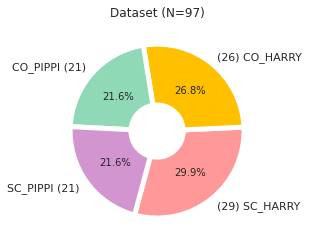

In [3]:
################################################################################# 2. Group the Data: Coherent ENG+GER, HARRY AND PIPPI

                                                                                # SENT_GROUP_INFO.xlsx
sg_harry = s_group['TEXT'] == 'HARRY'                                           # return true only for HARRY
sg_pippi = s_group['TEXT'] == 'PIPPI'                                           # return true only for PIPPI
sg_coherent = s_group['CONDITION'] == 'COHERENT'                                # return true only for COHERENT
sg_scrambled = s_group['CONDITION'] == 'SCRAMBLED'                              # return true only for SCRAMBLED
sg_eng = s_group['QESTN_LANGUAGE'] == 'ENG'                                     # return true only for ENG
sg_ger = s_group['QESTN_LANGUAGE'] == 'GER'                                     # return true only for GER

                                                                                # SENT_RATING_DATA.xlsx
sr_harry = s_rating['TEXT'] == 'HARRY'                                          # retrun true only for HARRY
sr_pippi = s_rating['TEXT'] == 'PIPPI'                                          # retrun true only for PIPPI
sr_coherent = s_rating['CONDITION'] == 'COHERENT'                               # retrun true only for COHERENT
sr_scrambled = s_rating['CONDITION'] == 'SCRAMBLED'                             # retrun true only for SCRAMBLED
sr_eng = s_rating['LANGUAGE'] == 'ENG'                                          # retrun true only for ENG
sr_ger = s_rating['LANGUAGE'] == 'GER'                                          # retrun true only for GER

                                                                                # Data filtering in the certain conditions
sg_co_harry = s_group[sg_harry & sg_coherent]                                   # Text: HARRY; Condition: COHERENT
sg_sc_harry = s_group[sg_harry & sg_scrambled]                                  # Text: HARRY; Condition: SCRAMBLED
sg_co_pippi = s_group[sg_pippi & sg_coherent]                                   # Text: PIPPI; Condition: COHERENT
sg_sc_pippi = s_group[sg_pippi & sg_scrambled]                                  # Text: PIPPI; Condition: SCRAMBLED

categories = ['(29) SC_HARRY','(26) CO_HARRY','CO_PIPPI (21)','SC_PIPPI (21)']  # Plot a pie chart of the distribution of the whole dataset (N=97)
sizes = [len(sg_sc_harry),len(sg_co_harry),len(sg_sc_pippi),len(sg_sc_pippi)]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=255,
       colors=colors,wedgeprops=wedgeprops)
plt.title('Dataset (N=97)')
plt.show()

bad data case list: [9, 19, 48, 84, 96, 87]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


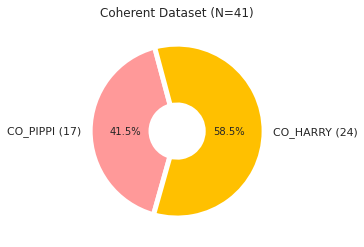

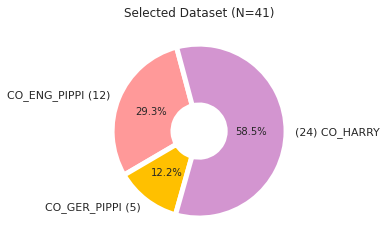

In [4]:
################################################################################# 3. Select the Data (Exclude the "bad data") and visualisation
sg_co = s_group[sg_coherent]
sr_co = s_rating[sr_coherent]
                                                                                ### Selecting the cases with "bad data"

                                                                                #Criteria that renders a case as "bad data" are:
b_DEG = sg_co.loc[sg_co['DEG_TIME']>100]['CASE']                                #       1. DEG_TIME > 100 (completion of the survey was too fast)

b_ATT = sg_co.loc[sg_co['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS']>0]['CASE']      #       2. ATTENTION_CHECKS_COUNT_WRONG_ANSWERS > 0 (clicking random answeres)

b_PAG = sr_co.loc[sr_co['PAGE_TIME']>999]['CASE']                               #       3. PAGE_TIME > 999 (pausing while completing the survey, can interfere with immersion)

b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)                             # Concatenate the "bad data" described above into a single list

b_list = b_list.drop_duplicates()                                               # Delete the duplicates
b_case = list(b_list.values)                                                    # Make of list of the cases considered to be "bad data" (list of case number)
print('bad data case list:',b_case)

                                                                                
                                                                                ### Excluding the "bad data" cases from the dataset

a_group = sg_co.copy()                                                          # Copy the SENT_GROUP_INFO.coherent
a_rating = sr_co.copy()                                                         # Copy the # SENT_RATING_DATA.coherent

for i in b_case:                                                                # Exclude the bad case from the coherent dataset
    a_rating = a_rating.drop(a_rating[a_rating['CASE'] == i].index)
    a_group = a_group.drop(a_group[a_group['CASE'] == i].index)

sg_co_harry = a_group[sg_harry & sg_coherent]                                   # Text: HARRY; Condition: COHERENT, bad data excluded
sg_sc_harry = a_group[sg_harry & sg_scrambled]                                  # Text: HARRY; Condition: SCRAMBLED, bad data excluded
sg_co_pippi = a_group[sg_pippi & sg_coherent]                                   # Text: PIPPI; Condition: COHERENT, bad data excluded
sg_sc_pippi = a_group[sg_pippi & sg_scrambled]                                  # Text: PIPPI; Condition: SCRAMBLED, bad data excluded
sg_co_en_pippi = a_group[sg_pippi & sg_coherent & sg_eng]                       # Text: PIPPI; Condition: COHERENT; Language: ENG
sg_co_ge_pippi = a_group[sg_pippi & sg_coherent & sg_ger]                       # Text: PIPPI; Condition: COHERENT; Language: GER

categories = ['CO_PIPPI (17)','CO_HARRY (24)']                                  # Plot the pie chart of the distribution of the COHERENT dataset (N=41)
                                                                                # Two pie chart slices:                                                                               
sizes = [len(sg_co_pippi),len(sg_co_harry)]                                     #    Text: PIPPI; Condition: COHERENT
colors = ['#ff9999', '#ffc000']                                                 #    Text: HARRY; Condition: COHERENT
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=105,
       colors=colors,wedgeprops=wedgeprops)
plt.title('Coherent Dataset (N=41)')                                            
plt.show()                                                                     


categories = ['CO_ENG_PIPPI (12)','CO_GER_PIPPI (5)','(24) CO_HARRY']           # Plot the pie chart of the distribution of the COHERENT dataset (N=41)
sizes = [len(sg_co_en_pippi),len(sg_co_ge_pippi),len(sg_co_harry)]              # Three pie chart slices: 
colors = ['#ff9999', '#ffc000','#d395d0']                                       #    Text: HARRY; Condition: COHERENT 
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}                     #    Text: PIPPI; Condition: COHERENT; Language: ENG
                                                                                #    Text: PIPPI; Condition: COHERENT; Language: GER
fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=105,                # 
       colors=colors,wedgeprops=wedgeprops)                                     # 
plt.title('Selected Dataset (N=41)')                                            #
plt.show()                                                                      #

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


HARRY
CASE              0
AROUSAL_RATING    0
VALENCE_RATING    0
dtype: int64 NaN
PIPPI
CASE              0
AROUSAL_RATING    0
VALENCE_RATING    0
dtype: int64 NaN
Coherent demographic informations: 
            CASE  ...   DEG_TIME
count  24.000000  ...  24.000000
mean   39.916667  ...  12.625000
std    24.313025  ...  11.948485
min     3.000000  ...   0.000000
25%     9.500000  ...   6.000000
50%    52.500000  ...   9.000000
75%    58.250000  ...  14.500000
max    64.000000  ...  45.000000

[8 rows x 22 columns]
              CASE    PAGE_TIME  ...  AROUSAL_RATING  VALENCE_RATING
count  3000.000000  3000.000000  ...     3000.000000     3000.000000
mean     39.916667    18.652667  ...        3.129333        4.545333
std      23.805082    26.659175  ...        0.923521        1.340601
min       3.000000     2.000000  ...        1.000000        1.000000
25%       9.500000     8.000000  ...        3.000000        4.000000
50%      52.500000    11.000000  ...        3.000000        4.00

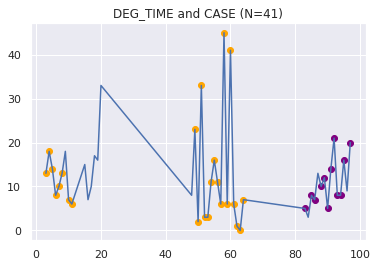

b_DEG []


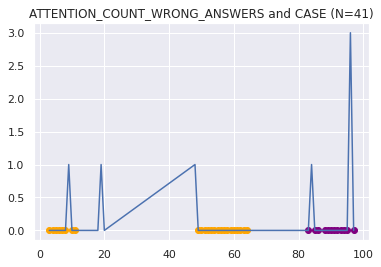

b_ATT [9, 19, 48, 84, 96]


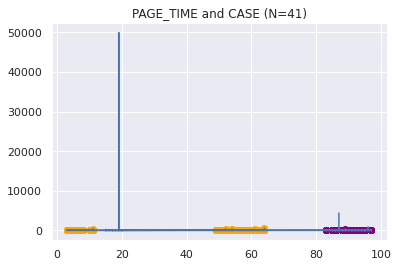

b_PAG [19, 19, 19, 87]


In [5]:
################################################################################# 4. Set the data with Condition: COHERENT only
                                                                                # Loading data from SENT_RATING file for:
ar_co_harry = a_rating[sr_harry & sr_coherent]                                  #   Text: HARRY; Condition: COHERENT
ar_co_pippi = a_rating[sr_pippi & sr_coherent & sr_eng]                         #   Text: PIPPI; Condition: COHERENT; Language: ENG

                                                                                #  Loading data from SENT_GROUP_INFO file for:
ag_co_harry = a_group[sg_harry & sg_coherent]                                   #   Text: HARRY; Condition: COHERENT
ag_co_pippi = a_group[sg_pippi & sg_coherent & sg_eng]                          #   Text: PIPPI; Condition: COHERENT; Language: ENG

################################################################################# 5. Drop out the NaN column from the data from SENT_GROUP_INFO file
gh = ag_co_harry                                                                # Text: HARRY; Condition: COHERENT
gp = ag_co_pippi                                                                # Text: PIPPI; Condition: COHERENT; Language: ENG
                                                                                # Charachter names: legend
rh = ar_co_harry.loc[:,['CASE','AROUSAL_RATING','VALENCE_RATING']]              # Text: HARRY; Condition: COHERENT in SENT_RATING_DATA
                                                                                # rh = ratings harry from file SENT_RATING
                                                                                #      contains: CASE, AROUSAL ratings, VALENCE ratings for Text: HARRY; Condition: COHERENT
rp = ar_co_pippi.loc[:,['CASE','AROUSAL_RATING','VALENCE_RATING']]              # Text: PIPPI; Condition: COHERENT; Language: ENG in SENT_RAITING_DATA
rp = rp.dropna(axis=0)                                                          # drop out NaN row
                                                                                # rp = ratings pippi from file SENT_RATING
                                                                                #      contains: CASE, AROUSAL ratings, valence ratings for Text: PIPPI; Condition: COHERENT; Language: ENG
print('HARRY')
print(rh.isnull().sum(), 'NaN')                                                 # check the NaN
print('PIPPI')
print(rp.isnull().sum(), 'NaN')                                                 # check the NaN

print("Coherent demographic informations: ")                                    # Demographic info on the countable columns
print(ag_co_harry.describe())
print(ar_co_harry.describe())

plt.title('DEG_TIME and CASE (N=41)')                                           # Plot the DEG_TIME
plt.scatter(ag_co_harry['CASE'], ag_co_harry['DEG_TIME'], c='orange')
plt.scatter(ag_co_pippi['CASE'], ag_co_pippi['DEG_TIME'], c='purple')
plt.plot(sg_co['CASE'], sg_co['DEG_TIME'])
plt.show()
print('b_DEG', list(b_DEG))                                                     # Print the case of DEG_TIME

plt.title('ATTENTION_COUNT_WRONG_ANSWERS and CASE (N=41)')                      # Plot the ATTENTION_COUNT_WRONG_ANSWERS
plt.scatter(ag_co_harry['CASE'],ag_co_harry['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'],c='orange')
plt.scatter(ag_co_pippi['CASE'],ag_co_pippi['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'],c='purple')
plt.plot(sg_co['CASE'],sg_co['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'])
plt.show()
print('b_ATT', list(b_ATT))                                                     # Print the case of ATTENTION_CHECKS_COUNT_WRONG_ANSWERS

plt.title('PAGE_TIME and CASE (N=41)')                                          # Plot the PAGE_TIME
plt.scatter(ar_co_harry['CASE'], ar_co_harry['PAGE_TIME'], c='orange')
plt.scatter(ar_co_pippi['CASE'], ar_co_pippi['PAGE_TIME'], c='purple')
plt.plot(sr_co['CASE'], sr_co['PAGE_TIME'])
plt.show()
print('b_PAG', list(b_PAG))                                                     # Print the case of PAGE_TIME

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


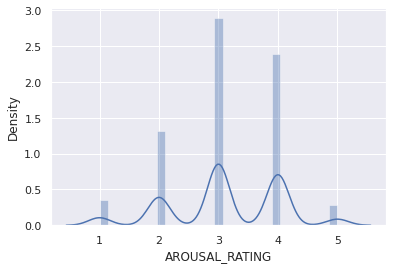

In [6]:
s_rating_filtered = rh.filter(["VALENCE_RATING", "AROUSAL_RATING"])             # Plot the AROUSAL_RATING and VALENCE_RATING HARRY distribution
sns.distplot(s_rating_filtered["AROUSAL_RATING"])                               # AROUSAL_RATING in Text: HARRY; Condition: COHERENT

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


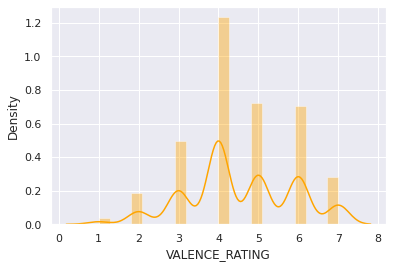

In [7]:
sns.distplot(s_rating_filtered['VALENCE_RATING'], color='orange')               # Plot the VALENCE_RATING in Text: HARRY; Condition: COHERENT

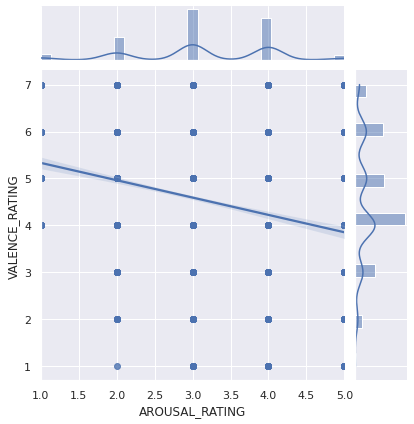

In [8]:
sns.jointplot(x='AROUSAL_RATING',y='VALENCE_RATING',                            # Joint plot of the both VALENCE_RATING and AROUSAL_RATING in HARRY
              data = s_rating_filtered,kind='reg')                              # Text: HARRY; Condition: COHERENT

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


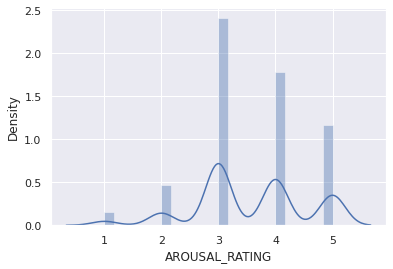

In [9]:
s_rating_filtered = rp.filter(["VALENCE_RATING", "AROUSAL_RATING"])             # Plot the AROUSAL_RATING and VALENCE_RATING PIPPI distribution
sns.distplot(s_rating_filtered["AROUSAL_RATING"])                               # AROUSAL_RATING in Text: PIPPI; Condition: COHERENT; Language: ENG

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


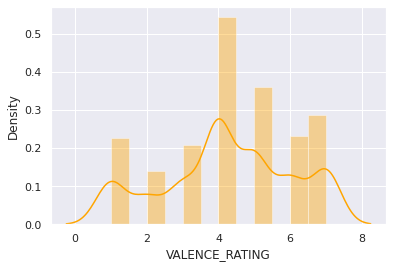

In [10]:
sns.distplot(s_rating_filtered['VALENCE_RATING'], color='orange')               # Plot the VALENCEL_RATING in Text: PIPPI; Condition: COHERENT; Language: ENG

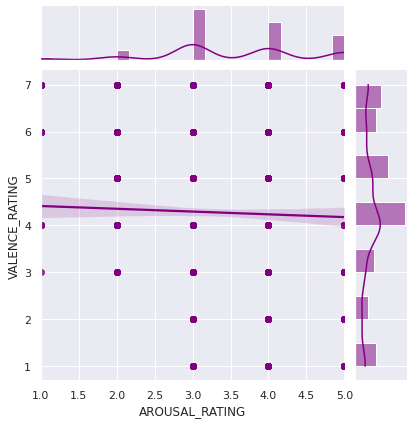

In [11]:
sns.jointplot(x='AROUSAL_RATING',y='VALENCE_RATING',                            # Joint plot of the both VALENCE_RATING and AROUSAL_RATING in 
              data = s_rating_filtered,kind='reg',color ='purple')              # Text: PIPPI; Condition: COHERENT; Language: ENG

    CASE   TEXT  ... DEG_TIME IMMERSION
2      3  HARRY  ...       13     5.875
3      4  HARRY  ...       18     4.625
4      5  HARRY  ...       14     2.875
5      6  HARRY  ...        8     4.250
6      7  HARRY  ...       10     5.750
7      8  HARRY  ...       13     5.625
9     10  HARRY  ...        7     4.750
10    11  HARRY  ...        6     5.125
48    49  HARRY  ...       23     2.375
49    50  HARRY  ...        2     4.875

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


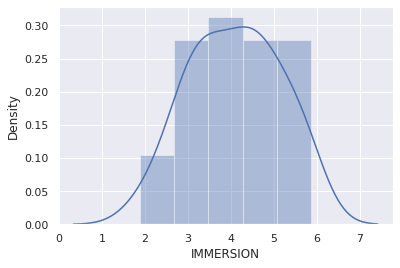

In [12]:
################################################################################ PART II: Data Preprocessing
                                                                                # 6. Compound the reader_response for immersion
rg_set = pd.concat([gh,gp], axis = 0)                                           # Merge the HARRY and PIPPI dataset
a_group = rg_set.copy()                                                         # Copy the dataset
h_group = gh.copy()
p_group = gp.copy()

## Characters names: legend:
# gh = data from SENT_GROUP_INFO Text: HARRY; Condition: COHERENT
#
# gp = data from SENT_GROUP_INFO Text: PIPPI; Condition: COHERENT; Language: ENG
#
# a_group: reading experience ratings for Text: HARRY; Condition: COHERENT and Text: PIPPI; Condition: COHERENT; Language: ENG
# h_group: reading experience ratings for Text: HARRY; Condition: COHERENT
# p_group: reading experience ratings for Text: PIPPI; Condition: COHERENT; Language: ENG

a_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'

reader_response = [16,17]                                                       # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    a_group['IMMERSION'] += a_group.iloc[:,i]

a_group['IMMERSION']=a_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(a_group.head(10))
sns.distplot(a_group["IMMERSION"])                                   

    CASE   TEXT  ... DEG_TIME IMMERSION
2      3  HARRY  ...       13  5.000000
3      4  HARRY  ...       18  4.309524
4      5  HARRY  ...       14  2.833333
5      6  HARRY  ...        8  4.357143
6      7  HARRY  ...       10  4.404762
7      8  HARRY  ...       13  5.357143
9     10  HARRY  ...        7  4.214286
10    11  HARRY  ...        6  3.261905
48    49  HARRY  ...       23  2.357143
49    50  HARRY  ...        2  4.190476

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


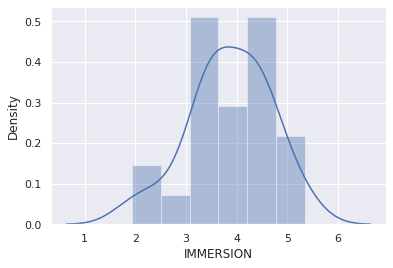

In [13]:
h_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION' for 
                                                                                # Text: HARRY, Condition: COHERENT
reader_response = [8,9,10,11,15,16,21]                                          # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    h_group['IMMERSION'] += h_group.iloc[:,i]

h_group['IMMERSION']=h_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(h_group.head(10))
sns.distplot(h_group["IMMERSION"])                                              

    CASE   TEXT  ... DEG_TIME IMMERSION
82    83  PIPPI  ...        5  4.880952
84    85  PIPPI  ...        8  3.142857
85    86  PIPPI  ...        7  3.690476
87    88  PIPPI  ...       10  4.357143
88    89  PIPPI  ...       12  3.047619
89    90  PIPPI  ...        5  4.476190
90    91  PIPPI  ...       14  4.285714
91    92  PIPPI  ...       21  3.880952
92    93  PIPPI  ...        8  3.357143
93    94  PIPPI  ...        8  3.547619

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


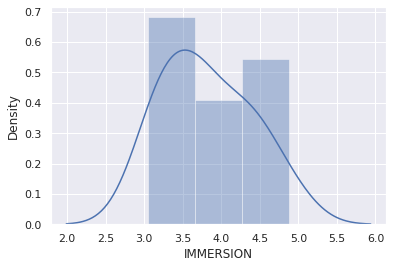

In [14]:
p_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'
                                                                                # For Text: PIppi, Condition: COHERENT, Language: ENG
reader_response = [8,9,10,11,15,16,21]                                          # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    p_group['IMMERSION'] += p_group.iloc[:,i]

p_group['IMMERSION']=p_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(p_group.head(10))
sns.distplot(p_group["IMMERSION"])   

In [15]:
################################################################################# 7. Preprocess the dataset
gh_case = list(a_group.loc[a_group['TEXT']=='HARRY'].loc[:,['CASE']]['CASE'])   # HARRY CASE LIST "print(len(gh_case))"
gp_case = list(a_group.loc[a_group['TEXT']=='PIPPI'].loc[:,['CASE']]['CASE'])   # PIPPI CASE LIST "print(len(gp_case))"

tr_hr_case = gh_case[2:22]                                                      # training set for Text: HARRY, Condition: COHERENT
te_hr_case = gh_case[0:2] + gh_case[22:25]                                      # testing set for Text: HARRY, Condition: COHERENT
hr_case = [tr_hr_case, te_hr_case]                                              # training and testing cases for Text: HARRY, Condition: COHERENT

tr_pi_case = gp_case[0:10]                                                      # training set for Text: PIPPI, Condition: COHERENT, Language = ENG
te_pi_case = gp_case[10:14]                                                     # testing set for Text: PIPPI, Condition: COHERENT, Language = ENG
pi_case = [tr_pi_case, te_pi_case]                                              # PIPPI case

rh_set = rh.copy()                                                              # Load the independent variable related dataset
rp_set = rp.copy()

hr_train_arousal = []
hr_train_valence = []
hr_test_arousal = []
hr_test_valence = []

for i in hr_case:                                                               # Text: HARRY
    for j in i:                                                                 # Extract Arousal and Valence
        if i == tr_hr_case:
            set = rh_set[rh_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            hr_train_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            hr_train_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rh_set[rh_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            hr_test_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            hr_test_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

pi_train_arousal = []
pi_train_valence = []
pi_test_arousal = []
pi_test_valence = []

for i in pi_case:                                                               # Text: PIPPI
    for j in i:                                                                 # Extract Arousal and Valence
        if i == tr_pi_case:
            set = rp_set[rp_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            pi_train_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            pi_train_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rp_set[rp_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            pi_test_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            pi_test_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

print('Coherent HARRY Dataset')                                                 # Set the input data for training set (as x_Train) and testing set (as x_Test)
print('train_arousal:',len(hr_train_arousal),hr_train_arousal)                  # The input data consists of the arounsal and valence ratings
print('train_valence:',len(hr_train_valence),hr_train_valence)
print('test_arousal:',len(hr_test_arousal),hr_test_arousal)
print('test_valence:',len(hr_test_valence),hr_test_valence)

print('Coherent PIPPI Dataset')
print('train_arousal:',len(pi_train_arousal),pi_train_arousal)
print('train_valence:',len(pi_train_valence),pi_train_valence)
print('test_arousal:',len(pi_test_arousal),pi_test_arousal)
print('test_valence:',len(pi_test_valence),pi_test_valence)

Coherent HARRY Dataset
train_arousal: 20 [[5.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0], [4.0, 4.0, 4.0, 2.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 4.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 1.0, 4.0, 3.0, 5.0, 5.0, 4.0, 2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 4.0, 2.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 

In [16]:
################################################################################ Set the output data for the training set (as Y_Train) and test set (as Y_Test)
hr_train_immersion = []                                                         # The output data consists of the Immersion level as calculated above
hr_test_immersion = []

for i in hr_case:                                                               # HARRY IMMERSION DATASET
    for j in i:
        if i == tr_hr_case:
            hr_train_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))
        else:
            hr_test_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))

print('hr_train_immersion',len(hr_train_immersion),hr_train_immersion)
print('hr_test_immersion',len(hr_test_immersion),hr_test_immersion)

# PIPPI IMMERSION DATASET
pi_train_immersion = []
pi_test_immersion = []

for i in pi_case:                                                               # PIPPI IMMERSION DATASET
    for j in i:
        if i == tr_pi_case:
            pi_train_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))
        else:
            pi_test_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))

print('pi_train_immersion',len(pi_train_immersion),pi_train_immersion)
print('pi_test_immersion',len(pi_test_immersion),pi_test_immersion)

hr_train_immersion 20 [[2.875], [4.25], [5.75], [5.625], [4.75], [5.125], [2.375], [4.875], [3.75], [4.125], [3.25], [3.25], [4.625], [5.5], [3.25], [5.75], [3.625], [1.875], [4.375], [3.75]]
hr_test_immersion 4 [[5.875], [4.625], [5.25], [4.25]]
pi_train_immersion 10 [[5.125], [3.125], [4.0], [3.5], [2.75], [3.625], [4.5], [4.875], [2.5], [3.0]]
pi_test_immersion 2 [[4.375], [3.125]]


In [17]:
################################################################################ Dataset as np.array
print('HARRY Dataset')                                                          # HARRY DATASET
hr_tr_arousal = np.array(hr_train_arousal)
hr_tr_valence = np.array(hr_train_valence)
hr_tr_immersion = np.array(hr_train_immersion)

hr_te_arousal = np.array(hr_test_arousal)
hr_te_valence = np.array(hr_test_valence)
hr_te_immersion = np.array(hr_test_immersion)

print('HARRY Training set')                                                     
print('hr_tr_arousal',hr_tr_arousal.shape,hr_tr_arousal)
print('hr_tr_valence',hr_tr_valence.shape,hr_tr_valence)
print('hr_tr_immersion',hr_tr_immersion.shape,hr_tr_immersion)

print('HARRY Test set')
print(hr_te_arousal)
print(hr_te_valence)
print(hr_te_immersion)

print('PIPPI Dataset')                                                          # PIPPI DATASET
pi_tr_arousal = np.array(pi_train_arousal)
pi_tr_valence = np.array(pi_train_valence)
pi_tr_immersion = np.array(pi_train_immersion)

pi_te_arousal = np.array(pi_test_arousal)
pi_te_valence = np.array(pi_test_valence)
pi_te_immersion = np.array(pi_test_immersion)

print('PIPPI Training set')
print('pi_tr_arousal',pi_tr_arousal.shape,pi_tr_arousal)
print('pi_tr_valence',pi_tr_valence.shape,pi_tr_valence)
print('pi_tr_immersion',pi_tr_immersion.shape,pi_tr_immersion)

print('PIPPI Test set')
print(pi_te_arousal)
print(pi_te_valence)
print(pi_te_immersion)

HARRY Dataset
HARRY Training set
hr_tr_arousal (20, 125) [[5. 4. 3. ... 2. 2. 2.]
 [4. 4. 4. ... 3. 4. 5.]
 [5. 4. 4. ... 4. 4. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 4. 5. ... 2. 2. 3.]
 [4. 4. 5. ... 3. 3. 2.]]
hr_tr_valence (20, 125) [[1. 2. 4. ... 5. 5. 6.]
 [5. 3. 5. ... 4. 4. 6.]
 [5. 5. 4. ... 5. 6. 7.]
 ...
 [4. 4. 3. ... 4. 4. 4.]
 [6. 6. 7. ... 6. 7. 6.]
 [6. 2. 7. ... 4. 4. 5.]]
hr_tr_immersion (20, 1) [[2.875]
 [4.25 ]
 [5.75 ]
 [5.625]
 [4.75 ]
 [5.125]
 [2.375]
 [4.875]
 [3.75 ]
 [4.125]
 [3.25 ]
 [3.25 ]
 [4.625]
 [5.5  ]
 [3.25 ]
 [5.75 ]
 [3.625]
 [1.875]
 [4.375]
 [3.75 ]]
HARRY Test set
[[4. 2. 1. 1. 1. 3. 4. 4. 2. 3. 3. 2. 4. 4. 3. 2. 2. 2. 2. 2. 4. 2. 1. 4.
  2. 2. 3. 2. 4. 3. 3. 2. 3. 2. 3. 2. 1. 4. 5. 4. 4. 2. 3. 3. 5. 1. 4. 3.
  4. 4. 2. 2. 1. 2. 2. 2. 2. 2. 4. 1. 3. 2. 4. 4. 4. 4. 5. 2. 2. 3. 4. 4.
  5. 2. 1. 3. 2. 1. 4. 4. 4. 2. 1. 4. 4. 2. 2. 1. 3. 1. 4. 3. 3. 4. 3. 4.
  4. 4. 2. 4. 3. 4. 2. 3. 4. 4. 4. 1. 2. 2. 3. 1. 1. 4. 4. 4. 4. 4. 2. 4.
  4. 3. 2. 1. 4.]

In [18]:
################################################################################# Concatenate to design flatten (1,) dataset
hr_tr_dataset = np.concatenate((hr_tr_arousal, hr_tr_valence), axis = 1)        #######   HARRY dataset
hr_te_dataset = np.concatenate((hr_te_arousal, hr_te_valence), axis = 1)        # In order to pass the input data in an optimal manner into the 
print(hr_tr_dataset.shape,'tr_dataset')                                         # machine learning algorithm, we will create an input dataset in the shape of 
print(hr_tr_dataset)                                                            # a two dimensional array (a, b) where
print(hr_te_dataset.shape,'te_dataset')                                         #   a=number of cases (2- fot the training set, 4 for the test set)
print(hr_te_dataset)                                                            #   b=250, in which the first 125 values represent the arousal scores 
                                                                                #     and the next 125 values represent the the valence scores

pi_tr_dataset = np.concatenate((pi_tr_arousal, pi_tr_valence), axis = 1)        #######    PIPPI dataset
pi_te_dataset = np.concatenate((pi_te_arousal, pi_te_valence), axis = 1)        # Same (a, b) structure as described above

(20, 250) tr_dataset
[[5. 4. 3. ... 5. 5. 6.]
 [4. 4. 4. ... 4. 4. 6.]
 [5. 4. 4. ... 5. 6. 7.]
 ...
 [3. 3. 3. ... 4. 4. 4.]
 [3. 4. 5. ... 6. 7. 6.]
 [4. 4. 5. ... 4. 4. 5.]]
(4, 250) te_dataset
[[4. 2. 1. 1. 1. 3. 4. 4. 2. 3. 3. 2. 4. 4. 3. 2. 2. 2. 2. 2. 4. 2. 1. 4.
  2. 2. 3. 2. 4. 3. 3. 2. 3. 2. 3. 2. 1. 4. 5. 4. 4. 2. 3. 3. 5. 1. 4. 3.
  4. 4. 2. 2. 1. 2. 2. 2. 2. 2. 4. 1. 3. 2. 4. 4. 4. 4. 5. 2. 2. 3. 4. 4.
  5. 2. 1. 3. 2. 1. 4. 4. 4. 2. 1. 4. 4. 2. 2. 1. 3. 1. 4. 3. 3. 4. 3. 4.
  4. 4. 2. 4. 3. 4. 2. 3. 4. 4. 4. 1. 2. 2. 3. 1. 1. 4. 4. 4. 4. 4. 2. 4.
  4. 3. 2. 1. 4. 5. 6. 6. 7. 7. 7. 7. 7. 7. 6. 3. 4. 4. 5. 7. 6. 6. 6. 6.
  5. 6. 6. 7. 3. 5. 7. 4. 7. 5. 6. 6. 3. 5. 7. 4. 2. 4. 5. 5. 3. 4. 5. 4.
  4. 3. 6. 7. 4. 5. 7. 6. 5. 4. 5. 5. 5. 5. 6. 4. 6. 6. 6. 5. 6. 3. 3. 3.
  4. 5. 4. 2. 3. 5. 7. 7. 7. 6. 7. 5. 6. 6. 6. 7. 3. 3. 5. 6. 7. 4. 7. 4.
  5. 3. 4. 4. 3. 2. 3. 5. 5. 4. 3. 3. 4. 5. 5. 5. 6. 5. 5. 7. 7. 7. 5. 6.
  7. 6. 3. 6. 3. 3. 6. 6. 7. 4.]
 [4. 4. 4. 3. 3. 4. 4. 4. 3. 3

In [19]:
################################################################################ PART III: Predictive Modeling
def MAE(y_train, y_pred):                                                       # 8. Define Evaluation Score, Mean Absolute Error (MAE)
  return np.mean(np.abs((y_train - y_pred)))

################################################################################# 9. Multiple Linear Regression for HARRY dataset (TEXT: Harry, CONDITION: COHERENT)
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

mlr = LinearRegression()
mlr.fit(x_train, y_train) 

print("train score")
y_pred = mlr.predict(x_train)

for i, e in enumerate(y_pred):
    print("expected_value",y_pred[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_train, y_pred))

print("test score")
y_pred0 = mlr.predict(x_test)

for i, e in enumerate(y_pred0):
    print("expected_value",y_pred0[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_test, y_pred0))

train score
expected_value [2.875] 	 real_value [2.875]
expected_value [4.25] 	 real_value [4.25]
expected_value [5.75] 	 real_value [5.75]
expected_value [5.625] 	 real_value [5.625]
expected_value [4.75] 	 real_value [4.75]
expected_value [5.125] 	 real_value [5.125]
expected_value [2.375] 	 real_value [2.375]
expected_value [4.875] 	 real_value [4.875]
expected_value [3.75] 	 real_value [3.75]
expected_value [4.125] 	 real_value [4.125]
expected_value [3.25] 	 real_value [3.25]
expected_value [3.25] 	 real_value [3.25]
expected_value [4.625] 	 real_value [4.625]
expected_value [5.5] 	 real_value [5.5]
expected_value [3.25] 	 real_value [3.25]
expected_value [5.75] 	 real_value [5.75]
expected_value [3.625] 	 real_value [3.625]
expected_value [1.875] 	 real_value [1.875]
expected_value [4.375] 	 real_value [4.375]
expected_value [3.75] 	 real_value [3.75]
MAE: 2.6201263381153696e-15
test score
expected_value [4.98822089] 	 real_value [2.875]
expected_value [4.00276053] 	 real_value [

In [20]:
################################################################################# 10. k-Neighbors-Regression for HARRY (TEXT: HARRY, CONDITION: COHERENT)
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

neigh = KNeighborsRegressor(n_neighbors = 5, weights = "distance")
neigh.fit(x_train, y_train) 

print("train score")
y_pred1 = neigh.predict(x_train)

for i, e in enumerate(y_pred1):
    print("expected_value",y_pred1[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_train, y_pred1))

print("test score")
y_pred2 = neigh.predict(x_test)

for i, e in enumerate(y_pred2):
    print("expected_value",y_pred2[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_test, y_pred2))

train score
expected_value [2.875] 	 real_value [2.875]
expected_value [4.25] 	 real_value [4.25]
expected_value [5.75] 	 real_value [5.75]
expected_value [5.625] 	 real_value [5.625]
expected_value [4.75] 	 real_value [4.75]
expected_value [5.125] 	 real_value [5.125]
expected_value [2.375] 	 real_value [2.375]
expected_value [4.875] 	 real_value [4.875]
expected_value [3.75] 	 real_value [3.75]
expected_value [4.125] 	 real_value [4.125]
expected_value [3.25] 	 real_value [3.25]
expected_value [3.25] 	 real_value [3.25]
expected_value [4.625] 	 real_value [4.625]
expected_value [5.5] 	 real_value [5.5]
expected_value [3.25] 	 real_value [3.25]
expected_value [5.75] 	 real_value [5.75]
expected_value [3.625] 	 real_value [3.625]
expected_value [1.875] 	 real_value [1.875]
expected_value [4.375] 	 real_value [4.375]
expected_value [3.75] 	 real_value [3.75]
MAE: 0.0
test score
expected_value [4.37732977] 	 real_value [2.875]
expected_value [3.61528883] 	 real_value [4.25]
expected_valu

In [21]:
################################################################################# 11. SVR, Support Vector Regressoion for HARRY (TEXT: HARRY, CONDITION: COHERENT)
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

SupportVectorRegModel = SVR()
SupportVectorRegModel.fit(x_train,y_train)

print("train score")
y_pred3 = SupportVectorRegModel.predict(x_train)

for i, e in enumerate(y_pred3):
    print("expected_value",y_pred3[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_train, y_pred3))

print("test score")
y_pred4 = SupportVectorRegModel.predict(x_test)

for i, e in enumerate(y_pred4):
    print("expected_value",y_pred4[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_test, y_pred4))

train score
expected_value 3.015100347623606 	 real_value [2.875]
expected_value 4.149793118065475 	 real_value [4.25]
expected_value 4.7163741815043165 	 real_value [5.75]
expected_value 5.151127341705058 	 real_value [5.625]
expected_value 4.6495959791151735 	 real_value [4.75]
expected_value 4.684362505066389 	 real_value [5.125]
expected_value 2.797561434026095 	 real_value [2.375]
expected_value 4.775097003408978 	 real_value [4.875]
expected_value 3.8094593579064724 	 real_value [3.75]
expected_value 4.224903032015559 	 real_value [4.125]
expected_value 3.3502218519718556 	 real_value [3.25]
expected_value 3.3502456097999143 	 real_value [3.25]
expected_value 4.683302023314211 	 real_value [4.625]
expected_value 4.812739852304009 	 real_value [5.5]
expected_value 3.3502218433315014 	 real_value [3.25]
expected_value 4.992482661488543 	 real_value [5.75]
expected_value 3.524824426044271 	 real_value [3.625]
expected_value 2.6977751651466364 	 real_value [1.875]
expected_value 4.37

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
################################################################################# 12. XGB Regression for HARRY (TEXT: HARRY, CONDITION: COHERENT)
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

xgb1 = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 2,n_jobs = 5,verbose=True)
xgb_grid.fit(x_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print("train score")
y_pred5= xgb_grid.predict(x_train)
for i, e in enumerate(y_pred5):
    print("expected_value",y_pred5[i], '\t', "real_value", y_train[i])

print('MAE:',MAE(y_train, y_pred5))

print("test score")
y_pred6 = xgb_grid.predict(x_test)
for i, e in enumerate(y_pred6):
    print("expected_value",y_pred6[i], '\t', "real_value", y_test[i])

print('MAE',MAE(y_test, y_pred6))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    7.3s finished


0.36338742441671157
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
train score
expected_value 2.8712053 	 real_value [2.875]
expected_value 4.246798 	 real_value [4.25]
expected_value 5.7406764 	 real_value [5.75]
expected_value 5.6238847 	 real_value [5.625]
expected_value 4.750317 	 real_value [4.75]
expected_value 5.124679 	 real_value [5.125]
expected_value 2.369713 	 real_value [2.375]
expected_value 4.87198 	 real_value [4.875]
expected_value 3.7467732 	 real_value [3.75]
expected_value 4.1253195 	 real_value [4.125]
expected_value 3.2460938 	 real_value [3.25]
expected_value 3.2475824 	 real_value [3.25]
expected_value 4.6228137 	 real_value [4.625]
expected_value 5.4976606 	 real_value [5.5]
expected_value 3.2489967 	 real_value [3.25]
expected_value 5.746959 	 real_value [5.75]
expected_value 3.6226304 	 real_value [3.625]
expected_value 1.93325

In [23]:
################################################################################# 13. NN Regression for HARRY (TEXT: HARRY, CONDITION: COHERENT)
x_train = hr_tr_dataset.copy()                                                  # Characteristics: 5 layers
x_test = hr_te_dataset.copy()                                                   # Layer 1: Input layer, size = x_train.shape[1] which is 250
y_train = hr_tr_immersion.copy()                                                # Layer 2, 3, 4: size = 64
y_test = hr_te_immersion.copy()                                                 # Layer 5: Output layer, size = 1

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 1ms/step - loss: 0.0796 - mae: 0.2608
expected_value 2.7864673137664795 	 real_value [2.875]
expected_value 3.900954484939575 	 real_value [4.25]
expected_value 5.534614562988281 	 real_value [5.75]
expected_value 5.146162986755371 	 real_value [5.625]
expected_value 4.455382347106934 	 real_value [4.75]
expected_value 4.936277389526367 	 real_value [5.125]
expected_value 2.2592861652374268 	 real_value [2.375]
expected_value 4.694335460662842 	 real_value [4.875]
expected_value 3.402698040008545 	 real_value [3.75]
expected_value 3.7581701278686523 	 real_value [4.125]
expected_value 3.0766541957855225 	 real_value [3.25]
expected_value 3.005875587463379 	 real_value [3.25]
expected_value 4.414076328277588 	 real_value [4.625]
expected_value 5.23731803894043 	 real_value [5.5]
expected_value 3.136697292327881 	 real_value [3.25]
expected_value 5.3009819984436035 	 real_value [5.75]
expected_value 3.3701224327087402 	 real_value [3.

In [24]:
################################################################################# 14. Multiple Linear Regression for PIPPI (TEXT: PIPPI, CONDITION: COHERENT)
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

mlr = LinearRegression()
mlr.fit(x_train, y_train) 

print("train score")
y_pred7 = mlr.predict(x_train)

for i, e in enumerate(y_pred7):
    print("expected_value",y_pred7[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_train, y_pred7))

print("test score")
y_pred8 = mlr.predict(x_test)

for i, e in enumerate(y_pred8):
    print("expected_value",y_pred8[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_test, y_pred8))

train score
expected_value [5.125] 	 real_value [5.125]
expected_value [3.125] 	 real_value [3.125]
expected_value [4.] 	 real_value [4.]
expected_value [3.5] 	 real_value [3.5]
expected_value [2.75] 	 real_value [2.75]
expected_value [3.625] 	 real_value [3.625]
expected_value [4.5] 	 real_value [4.5]
expected_value [4.875] 	 real_value [4.875]
expected_value [2.5] 	 real_value [2.5]
expected_value [3.] 	 real_value [3.]
MAE: 1.021405182655144e-15
test score
expected_value [3.88247776] 	 real_value [5.125]
expected_value [4.32639923] 	 real_value [3.125]
MAE: 0.8469607366568777


In [25]:
################################################################################# 15. k-Neighbors-Regression for PIPPI (TEXT: PIPPI, CONDITION: COHERENT)

x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

neigh = KNeighborsRegressor(n_neighbors = 5, weights = "distance")
neigh.fit(x_train, y_train) 

print("train score")
y_pred9 = neigh.predict(x_train)

for i, e in enumerate(y_pred9):
    print("expected_value",y_pred9[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_train, y_pred9))

print("test score")
y_pred10 = neigh.predict(x_test)

for i, e in enumerate(y_pred10):
    print("expected_value",y_pred10[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_test, y_pred10))

train score
expected_value [5.125] 	 real_value [5.125]
expected_value [3.125] 	 real_value [3.125]
expected_value [4.] 	 real_value [4.]
expected_value [3.5] 	 real_value [3.5]
expected_value [2.75] 	 real_value [2.75]
expected_value [3.625] 	 real_value [3.625]
expected_value [4.5] 	 real_value [4.5]
expected_value [4.875] 	 real_value [4.875]
expected_value [2.5] 	 real_value [2.5]
expected_value [3.] 	 real_value [3.]
MAE: 0.0
test score
expected_value [3.73527408] 	 real_value [5.125]
expected_value [3.33642856] 	 real_value [3.125]
MAE: 0.42557724193181845


In [26]:
################################################################################# 16. SVR, Support Vector Regression for PIPPI (TEXT: PIPPI, CONDITION: COHERENT)
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

SupportVectorRegModel = SVR()
SupportVectorRegModel.fit(x_train,y_train)

print("train score")
y_pred11 = SupportVectorRegModel.predict(x_train)

for i, e in enumerate(y_pred11):
    print("expected_value",y_pred11[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_train, y_pred11))

print("test score")
y_pred12 = SupportVectorRegModel.predict(x_test)

for i, e in enumerate(y_pred12):
    print("expected_value",y_pred12[i],'\t', "real_value",y_train[i])

print('MAE:',MAE(y_test, y_pred12))

train score
expected_value 4.080152618326251 	 real_value [5.125]
expected_value 3.2248166705616015 	 real_value [3.125]
expected_value 3.900206120589954 	 real_value [4.]
expected_value 3.3997710016874843 	 real_value [3.5]
expected_value 2.88003968002472 	 real_value [2.75]
expected_value 3.5474336934129567 	 real_value [3.625]
expected_value 3.9110822791777635 	 real_value [4.5]
expected_value 4.497416025508548 	 real_value [4.875]
expected_value 3.075462089993428 	 real_value [2.5]
expected_value 3.1002061446681513 	 real_value [3.]
MAE: 0.819507650115818
test score
expected_value 3.6075907809569103 	 real_value [5.125]
expected_value 3.7575456625971686 	 real_value [3.125]
MAE: 0.625


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
################################################################################# 17. XGB Regression for PIPPI (TEXT: PIPPI, CONDITION: COHERENT)
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 2,n_jobs = 5,verbose=True)
xgb_grid.fit(x_train,y_train)

print("train score")
y_pred13= xgb_grid.predict(x_train)
for i, e in enumerate(y_pred13):
    print("expected_value",y_pred13[i], '\t', "real_value", y_train[i])
print('MAE',MAE(y_test, y_pred13))

print("test score")
y_pred14 = xgb_grid.predict(x_test)
for i, e in enumerate(y_pred14):
    print("expected_value",y_pred14[i], '\t', "real_value", y_test[i])

print('MAE',MAE(y_test, y_pred14))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    3.1s finished


train score
expected_value 4.996421 	 real_value [5.125]
expected_value 3.133109 	 real_value [3.125]
expected_value 4.010928 	 real_value [4.]
expected_value 3.511552 	 real_value [3.5]
expected_value 2.7606344 	 real_value [2.75]
expected_value 3.6376016 	 real_value [3.625]
expected_value 4.511741 	 real_value [4.5]
expected_value 4.8872547 	 real_value [4.875]
expected_value 2.56929 	 real_value [2.5]
expected_value 3.0109565 	 real_value [3.]
MAE 0.8554535865783691
test score
expected_value 3.6232784 	 real_value [4.375]
expected_value 4.0763435 	 real_value [3.125]
MAE 0.625


In [28]:
################################################################################# 18. NN Regression for PIPPI (TEXT: PIPPI, CONDITION: COHERENT)
x_train = pi_tr_dataset.copy()                                                  # Characteristics of the neural network: see above (For Text: HARRY)
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.2419
expected_value 4.571701526641846 	 real_value [5.125]
expected_value 2.9235942363739014 	 real_value [3.125]
expected_value 3.667876958847046 	 real_value [4.]
expected_value 3.3875269889831543 	 real_value [3.5]
expected_value 2.6966187953948975 	 real_value [2.75]
expected_value 3.3920021057128906 	 real_value [3.625]
expected_value 3.9913361072540283 	 real_value [4.5]
expected_value 4.604605674743652 	 real_value [4.875]
expected_value 2.4514267444610596 	 real_value [2.5]
expected_value 2.89457631111145 	 real_value [3.]
test score
1/1 [==============================] - 0s 2ms/step - loss: 0.5111 - mae: 0.6727
expected_value 3.4604270458221436 	 real_value [4.375]
expected_value 3.5559241771698 	 real_value [3.125]


In [29]:
################################################################################# 19. Neural network, Regression: Hyperparameter Optimization
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

def gridsearch_model(neurons1, neurons2, neurons3):                             ######### Grid Search function
                                                                                ############  Input:
    model = models.Sequential()
    model.add(layers.Dense(neurons1, activation='relu',                         #   neurons1 : integer, first dropout layer parameter      
                       input_shape=(x_train.shape[1],)))
    model.add(Dense(neurons2,activation = 'relu'))                              #   neurons2 : integer, first dropout layer parameter
    model.add(Dense(neurons3,activation = 'relu'))                              #   neurons3 : integer, second dropout layer parameter
    model.add(Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])             ###### Output:
    return model                                                                #    This function returns a model

model = KerasRegressor(build_fn=gridsearch_model, nb_epoch=100,                 # Grid Search, Hyper-parameter tuning for Text: HARRY, Condition: COHERENT
                       batch_size=4, verbose=0)

neurons1 = [32,64,128]                                                               
neurons2 = [32,64,128]
neurons3 = [32,64,128]

param_grid = dict(neurons1 = neurons1,neurons2 = neurons2,neurons3=neurons3)    # Grid Search parameter on hyper parameters
grid = GridSearchCV(estimator = model, param_grid = param_grid,n_jobs=-1)       # GridSearchCV process constructs and evaluates a model 
grid_result = grid.fit(x_train,y_train)                                         # for each combination of parameters.

means = grid_result.cv_results_['mean_test_score']                              # Summarize results
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean,stdev,param in zip(means,stds,params):
    print("%f (%f) with: %r" % (mean,stdev,param))
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


-1.830935 (0.932740) with: {'neurons1': 32, 'neurons2': 32, 'neurons3': 32}
-2.259523 (2.824490) with: {'neurons1': 32, 'neurons2': 32, 'neurons3': 64}
-1.534408 (0.948777) with: {'neurons1': 32, 'neurons2': 32, 'neurons3': 128}
-2.026421 (1.375479) with: {'neurons1': 32, 'neurons2': 64, 'neurons3': 32}
-1.647124 (0.880410) with: {'neurons1': 32, 'neurons2': 64, 'neurons3': 64}
-1.373872 (0.989142) with: {'neurons1': 32, 'neurons2': 64, 'neurons3': 128}
-3.058556 (1.153176) with: {'neurons1': 32, 'neurons2': 128, 'neurons3': 32}
-3.240765 (4.178982) with: {'neurons1': 32, 'neurons2': 128, 'neurons3': 64}
-1.654245 (1.141222) with: {'neurons1': 32, 'neurons2': 128, 'neurons3': 128}
-3.775516 (2.907075) with: {'neurons1': 64, 'neurons2': 32, 'neurons3': 32}
-3.316265 (2.202007) with: {'neurons1': 64, 'neurons2': 32, 'neurons3': 64}
-2.737289 (1.620254) with: {'neurons1': 64, 'neurons2': 32, 'neurons3': 128}
-1.565088 (0.855443) with: {'neurons1': 64, 'neurons2': 64, 'neurons3': 32}
-1.30

[128, 64, 128]
processing fold #: 1
processing fold #: 2
processing fold #: 3
processing fold #: 4
processing fold #: 5


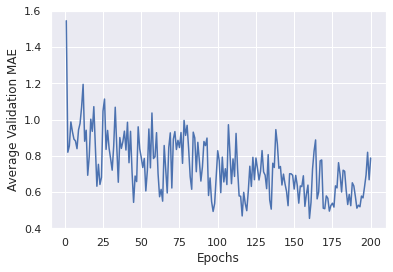

In [30]:
################################################################################# 20. Nueral network, Regression: Cross-Validation
para = grid_result.best_params_                                                 # Cross Validation for Text: HARRY, Condition: COHERENT
append = []
a_list = ['neurons1','neurons2','neurons3']
for i in a_list:
    append.append(para[i])
print(append)

k = 5                                                                           # K-fold cross-validation
num_val_samples = len(x_train) // k
num_epochs = 200
all_mae_scores = []

def build_model():                                                              ####### Define the model
    model = models.Sequential()                                                 # No Input
    model.add(layers.Dense(append[0], activation='relu',                        # Output: this function returns a model
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(append[1], activation='relu'))
    model.add(layers.Dense(append[2], activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

for i in range(k):
    print('processing fold #:', i+1)
    val_data = x_train[i*num_val_samples: (i + 1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
                                                                                # Build training and test sets
    partial_x_train = np.concatenate(                                           
        [x_train[:i * num_val_samples],
         x_train[(i+1) * num_val_samples:]],
         axis = 0)                                                              # partial_x_train: contains k-1 subgroups of the total train input dataset
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
         axis=0)                                                                # partial_train_targets: contains k-1 subgroups of the total train output data

    model = build_model()
    history = model.fit(partial_x_train, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=4, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_scores.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)             # Validation MAE Visualization
plt.xlabel('Epochs')
plt.ylabel('Average Validation MAE')
plt.show()

In [33]:
################################################################################# 21. Neural network, Regression: Evaluation
para = grid_result.best_params_                                                 # Final train and test of Text: HARRY, Condition: COHERENT
append = []
alist = ['neurons1','neurons2','neurons3']
for i in alist:
    print(para[i])
    append.append(para[i])
print(append)

model = models.Sequential()
model.add(layers.Dense(append[0], activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(append[1], activation='relu'))
model.add(layers.Dense(append[2], activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train,y_train,epochs=115,batch_size=20,verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

128
64
128
[128, 64, 128]
train score
1/1 [==============================] - 0s 1ms/step - loss: 0.7142 - mae: 0.7523
expected_value 3.7910072803497314 	 real_value [2.875]
expected_value 4.781263828277588 	 real_value [4.25]
expected_value 5.136024475097656 	 real_value [5.75]
expected_value 5.991968631744385 	 real_value [5.625]
expected_value 5.299577236175537 	 real_value [4.75]
expected_value 5.389028072357178 	 real_value [5.125]
expected_value 3.623584747314453 	 real_value [2.375]
expected_value 5.070166110992432 	 real_value [4.875]
expected_value 4.4154953956604 	 real_value [3.75]
expected_value 4.801720142364502 	 real_value [4.125]
expected_value 4.2774658203125 	 real_value [3.25]
expected_value 4.591536045074463 	 real_value [3.25]
expected_value 5.699834823608398 	 real_value [4.625]
expected_value 5.188065052032471 	 real_value [5.5]
expected_value 4.420626163482666 	 real_value [3.25]
expected_value 5.542863845825195 	 real_value [5.75]
expected_value 4.36512422561645

BFI_EXTRAVERSION
R2:  0.17926608088250362
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     7.426
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0101
Time:                        16:01:20   Log-Likelihood:                -48.961
No. Observations:                  36   AIC:                             101.9
Df Residuals:                      34   BIC:                             105.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

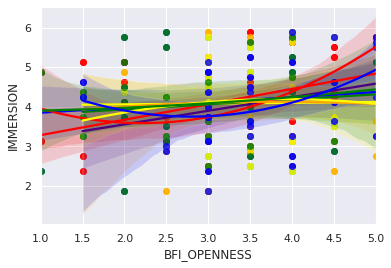

In [34]:
################################################################################ PART IV: Statistical Analysis with BIG FIVE
################################################################################# 22. Statistical Analysises between Immersion and 5 BFI (TEXT: HARRY; PIPPI)
                                                                                # Using linear regression, ordinary least square
e_group = a_group.copy()                                                        # Text: HARRY; PIPPI, Condition: COHERENT, Immersion: 2 Reader_Response
e_group.head()

bfi_list = []
for i in range(5):
    bfi_list.append(e_group.columns[i+4])

def immersion_bfi_sa(bfi_list):                                                 # Function for the Statistical Analysis
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = e_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):                                                 # Function for the Plot the IMMERSION and BFI in linear regression
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = e_group, color = color[i])

def immersion_bfi_pl2(bfi_list):                                                # Function for the Plot the IMMERSION and BFI in nonlinear regression
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = e_group,
                    color = color[i], order = 2)

immersion_bfi_sa(bfi_list)                                                      # Statistical Analysis
immersion_bfi_pl(bfi_list)                                                      # Plot the IMMERSION and BFI in linear regression
immersion_bfi_pl2(bfi_list)                                                     # Plot the IMMERSION and BFI in nonlinear regression

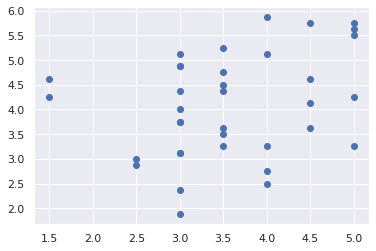

In [35]:
################################################################################# BFI_OPENNESS and IMMERSION distribution
x = e_group['BFI_OPENNESS']                                                     # BFI_OPENNESS and IMMERSION
y = e_group['IMMERSION']
plt.scatter(x,y)

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.262
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0798
Time:                        16:01:27   Log-Likelihood:                -50.868
No. Observations:                  36   AIC:                             105.7
Df Residuals:                      34   BIC:                             108.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8674      0.698  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


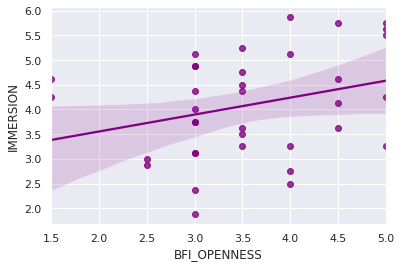

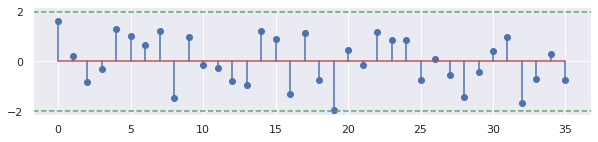

In [36]:
################################################################################ IMMERSION and BFI OPENNESS
res = smf.ols(formula='IMMERSION ~ BFI_OPENNESS', data = e_group).fit()         # Using linear regression, oridnary least square
sns.regplot(x="BFI_OPENNESS", y="IMMERSION", data=e_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

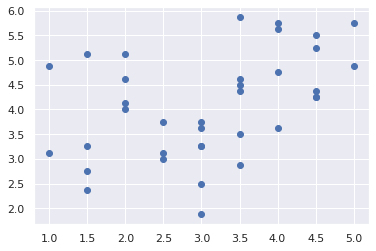

In [37]:
################################################################################# BFI_EXTRAVERSION and IMMERSION
x = e_group['BFI_EXTRAVERSION']                                                 # BFI_EXTRAVERSION and IMMERSION distribution
y = e_group['IMMERSION']
plt.scatter(x,y)

BFI_EXTRAVERSION
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     7.426
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0101
Time:                        16:01:32   Log-Likelihood:                -48.961
No. Observations:                  36   AIC:                             101.9
Df Residuals:                      34   BIC:                             105.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


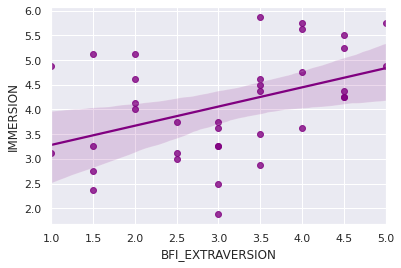

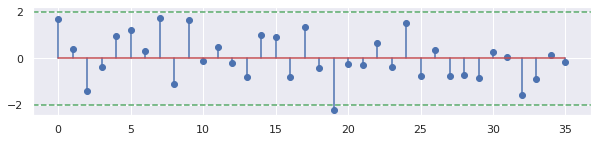

In [38]:
################################################################################# IMMERSION AND BFI_EXTRAVERSION
                                                                                # Using linear regression, oridnary least square
res = smf.ols(formula='IMMERSION ~ BFI_EXTRAVERSION', data = e_group).fit()
sns.regplot(x="BFI_EXTRAVERSION", y="IMMERSION", data=e_group, color='purple')
print('BFI_EXTRAVERSION')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

BFI_EXTRAVERSION
R2:  0.17074158900135838
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     4.530
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0448
Time:                        16:01:35   Log-Likelihood:                -26.353
No. Observations:                  24   AIC:                             56.71
Df Residuals:                      22   BIC:                             59.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

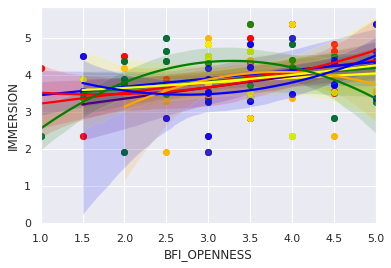

In [39]:
################################################################################# 23. Statistical Analysises between Immersion and 5 BFI (TEXT: HARRY)
                                                                                # Using linear regression, ordinary least square
e_group = h_group.copy()                                                        # Text: HARRY, Condition: COHERENT, Immersion: 2 Reader_Response
e_group.head()

bfi_list = []
for i in range(5):
    bfi_list.append(e_group.columns[i+4])

def immersion_bfi_sa(bfi_list):                                                 # Function for the Statistical Analysis
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = e_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):                                                 # Function for the Plot the IMMERSION and BFI in linear regression
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = e_group, color = color[i])

def immersion_bfi_pl2(bfi_list):                                                # Function for the Plot the IMMERSION and BFI in nonlinear regression
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = e_group,
                    color = color[i], order = 2)

immersion_bfi_sa(bfi_list)                                                      # Statistical Analysis
immersion_bfi_pl(bfi_list)                                                      # Plot the IMMERSION and BFI in linear regression
immersion_bfi_pl2(bfi_list)                                                     # Plot the IMMERSION and BFI in nonlinear regression

BFI_EXTRAVERSION
R2:  0.17098425205754597
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     2.062
Date:                Sun, 04 Oct 2020   Prob (F-statistic):              0.181
Time:                        16:01:39   Log-Likelihood:                -8.8201
No. Observations:                  12   AIC:                             21.64
Df Residuals:                      10   BIC:                             22.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/sea

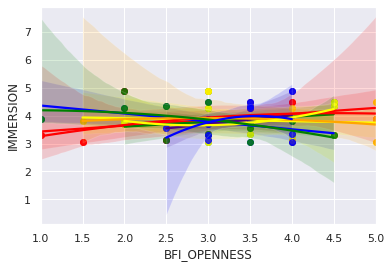

In [40]:
################################################################################# 24. Statistical Analysises between Immersion and 5 BFI (TEXT: PIPPI)
                                                                                # Using linear regression, ordinary least square
e_group = p_group.copy()                                                        # Text: PIPPI, Condition: COHERENT, Immersion: 3 Reader_Response
e_group.head()

bfi_list = []
for i in range(5):
    bfi_list.append(e_group.columns[i+4])

def immersion_bfi_sa(bfi_list):                                                 # Function for the Statistical Analysis
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = e_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):                                                 # Function for the Plot the IMMERSION and BFI in linear regression
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = e_group, color = color[i])

def immersion_bfi_pl2(bfi_list):                                                # Function for the Plot the IMMERSION and BFI in nonlinear regression
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = e_group,
                    color = color[i], order = 2)

immersion_bfi_sa(bfi_list)                                                      # Statistical Analysis
immersion_bfi_pl(bfi_list)                                                      # Plot the IMMERSION and BFI in linear regression
immersion_bfi_pl2(bfi_list)                                                     # Plot the IMMERSION and BFI in nonlinear regression

[34, 36, 9, 13, 19, 22, 24, 26, 30, 35, 43, 44, 48, 65, 84, 96, 68, 74, 77, 82, 87, 31, 39, 46]
    CASE   TEXT  ... DEG_TIME IMMERSION
0      1  HARRY  ...       50  4.125000
1      2  HARRY  ...       15  4.517857
2      3  HARRY  ...       13  4.625000
3      4  HARRY  ...       18  3.803571
4      5  HARRY  ...       14  2.803571
5      6  HARRY  ...        8  4.178571
6      7  HARRY  ...       10  4.571429
7      8  HARRY  ...       13  4.982143
9     10  HARRY  ...        7  4.071429
10    11  HARRY  ...        6  3.446429

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


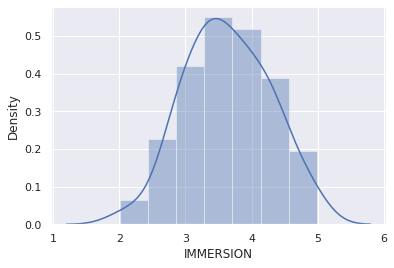

In [41]:
################################################################################# Statistical Analysises between Immersion and 5 BFI: Artihmetic Mean
                                                                                # 25. Immersion and BIG_FIVE: All Reader_response (CONDITION: COHERENT; SCRAMBLED)
e_group = p_group.copy()                                                        # Text: HARRY; PIPPI, Condition: COHERENT; SCRAMBLED
e_group.head()

b_DEG = s_group.loc[s_group['DEG_TIME']>100]['CASE']
b_ATT = s_group.loc[s_group['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS']>0]['CASE']
b_PAG = s_rating.loc[s_rating['PAGE_TIME']>999]['CASE']
b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)
b_list = b_list.drop_duplicates()
b_case = list(b_list.values)
print(b_case)

e_group = []
e_rating = []
a_group = s_group.copy()
a_rating = s_rating.copy()

for i in b_case:
    a_rating = a_rating.drop(a_rating[a_rating['CASE'] == i].index)
    a_group = a_group.drop(a_group[a_group['CASE'] == i].index)
    if i == 46:
        e_group = a_group
        e_rating = a_rating

e_group['IMMERSION'] = 0

for i in range (14):
    e_group['IMMERSION'] += e_group.iloc[:,i+4]

e_group['IMMERSION']=e_group['IMMERSION']/14
print(e_group.head(10))
sns.distplot(e_group["IMMERSION"])

BFI_EXTRAVERSION
R2:  0.028141345238469007
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.056
Date:                Sun, 04 Oct 2020   Prob (F-statistic):              0.156
Time:                        16:01:47   Log-Likelihood:                -69.728
No. Observations:                  73   AIC:                             143.5
Df Residuals:                      71   BIC:                             148.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

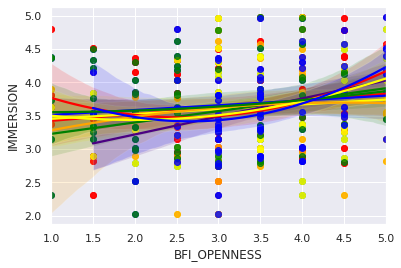

In [42]:
################################################################################# Correlation between BIG FIVE and IMMERSION 
bfi_list = []
for i in range(5):
  bfi_list.append(e_group.columns[i+4])

immersion_bfi_sa(bfi_list)
immersion_bfi_pl(bfi_list)
immersion_bfi_pl2(bfi_list)

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     5.091
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0271
Time:                        16:01:51   Log-Likelihood:                -68.242
No. Observations:                  73   AIC:                             140.5
Df Residuals:                      71   BIC:                             145.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


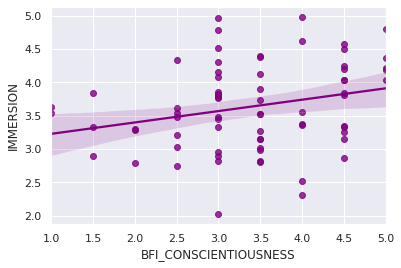

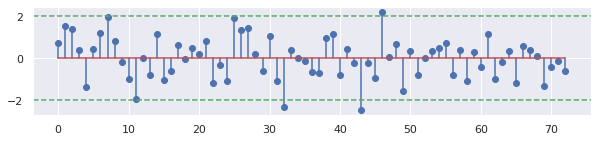

In [43]:
################################################################################ IMMERSION and BFI OPENNESS
res = smf.ols(formula='IMMERSION ~ BFI_CONSCIENTIOUSNESS', data = e_group).fit()         # Using linear regression, oridnary least square
sns.regplot(x="BFI_CONSCIENTIOUSNESS", y="IMMERSION", data=e_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     10.03
Date:                Sun, 04 Oct 2020   Prob (F-statistic):            0.00227
Time:                        16:01:54   Log-Likelihood:                -65.948
No. Observations:                  73   AIC:                             135.9
Df Residuals:                      71   BIC:                             140.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6778      0.310  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


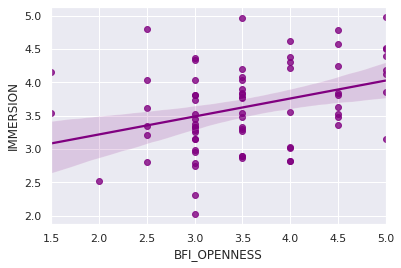

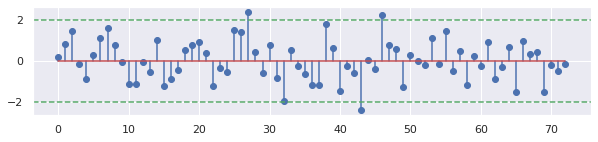

In [44]:
################################################################################ IMMERSION and BFI OPENNESS
res = smf.ols(formula='IMMERSION ~ BFI_OPENNESS', data = e_group).fit()         # Using linear regression, oridnary least square
sns.regplot(x="BFI_OPENNESS", y="IMMERSION", data=e_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

In [45]:
################################################################################# Statistical Analysises between Immersion and 5 BFI: Artihmetic Mean
                                                                                # 26. Immersion and BIG_FIVE: All Reader_response (CONDITION: COHERENT)
sg_co = s_group[sg_coherent]                                                    # Text: HARRY; PIPPI, Condition: COHERENT
sr_co = s_rating[sr_coherent]
                                                                                ### Selecting the cases with "bad data"

                                                                                # Criteria that renders a case as "bad data" are:
b_DEG = sg_co.loc[sg_co['DEG_TIME']>100]['CASE']                                #       1. DEG_TIME > 100 (completion of the survey was too fast)

b_ATT = sg_co.loc[sg_co['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS']>0]['CASE']      #       2. ATTENTION_CHECKS_COUNT_WRONG_ANSWERS > 0 (clicking random answeres)

b_PAG = sr_co.loc[sr_co['PAGE_TIME']>999]['CASE']                               #       3. PAGE_TIME > 999 (pausing while completing the survey, can interfere with immersion)

b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)                             # Concatenate the "bad data" described above into a single list

b_list = b_list.drop_duplicates()                                               # Delete the duplicates
b_case = list(b_list.values)                                                    # Make of list of the cases considered to be "bad data" (list of case number)
print('bad data case list:',b_case)
                                                                                
                                                                                ### Excluding the "bad data" cases from the dataset

a_group = sg_co.copy()                                                          # Copy the SENT_GROUP_INFO.coherent
a_rating = sr_co.copy()                                                         # Copy the # SENT_RATING_DATA.coherent

for i in b_case:                                                                # Exclude the bad case from the coherent dataset
    a_rating = a_rating.drop(a_rating[a_rating['CASE'] == i].index)
    a_group = a_group.drop(a_group[a_group['CASE'] == i].index)

sg_co_harry = a_group[sg_harry & sg_coherent]                                   # Text: HARRY; Condition: COHERENT, bad data excluded
sg_sc_harry = a_group[sg_harry & sg_scrambled]                                  # Text: HARRY; Condition: SCRAMBLED, bad data excluded
sg_co_pippi = a_group[sg_pippi & sg_coherent]                                   # Text: PIPPI; Condition: COHERENT, bad data excluded
sg_sc_pippi = a_group[sg_pippi & sg_scrambled]                                  # Text: PIPPI; Condition: SCRAMBLED, bad data excluded
sg_co_en_pippi = a_group[sg_pippi & sg_coherent & sg_eng]                       # Text: PIPPI; Condition: COHERENT; Language: ENG
sg_co_ge_pippi = a_group[sg_pippi & sg_coherent & sg_ger]                       # Text: PIPPI; Condition: COHERENT; Language: GER

                                                                                #  Loading data from SENT_GROUP_INFO file for:
ag_co_harry = a_group[sg_harry & sg_coherent]                                   #   Text: HARRY; Condition: COHERENT
ag_co_pippi = a_group[sg_pippi & sg_coherent & sg_eng]                          #   Text: PIPPI; Condition: COHERENT; Language: ENG
                                                                                # drop out the NaN column from the data from SENT_GROUP_INFO file:
gh = ag_co_harry                                                                # Text: HARRY; Condition: COHERENT
gp = ag_co_pippi                                                                # Text: PIPPI; Condition: COHERENT; Language: ENG

bad data case list: [9, 19, 48, 84, 96, 87]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

    CASE   TEXT  ... DEG_TIME IMMERSION
2      3  HARRY  ...       13  5.303571
3      4  HARRY  ...       18  4.065476
4      5  HARRY  ...       14  2.327381
5      6  HARRY  ...        8  4.071429
6      7  HARRY  ...       10  4.488095
7      8  HARRY  ...       13  5.375000
9     10  HARRY  ...        7  4.321429
10    11  HARRY  ...        6  3.863095
48    49  HARRY  ...       23  2.089286
49    50  HARRY  ...        2  4.255952

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


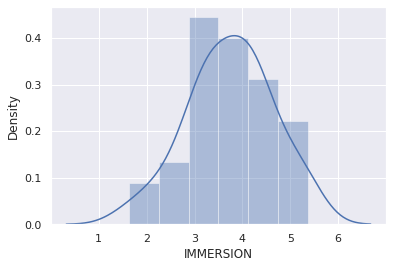

In [46]:
rg_set = pd.concat([gh,gp], axis = 0)                                           # Merge the HARRY and PIPPI dataset
a_group = rg_set.copy()                                                         # Copy the dataset
h_group = gh.copy()
p_group = gp.copy()

a_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'

reader_response = [9,10,11,12,13,14,15,16,17,18,19,20,21,22]                    # Use all reader's response
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    a_group['IMMERSION'] += a_group.iloc[:,i]

a_group['IMMERSION']=a_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(a_group.head(10))
sns.distplot(a_group["IMMERSION"])                          

BFI_EXTRAVERSION
R2:  0.14056425143200835
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     5.561
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0243
Time:                        16:02:11   Log-Likelihood:                -43.630
No. Observations:                  36   AIC:                             91.26
Df Residuals:                      34   BIC:                             94.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

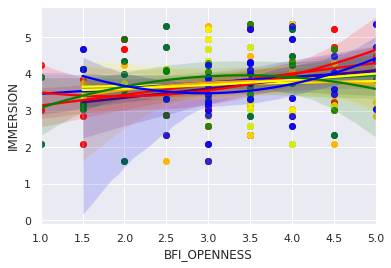

In [47]:
################################################################################# Statistical Analysises between Immersion and 5 BFI: Mean case
                                                                                # Using linear regression, ordinary least square
e_group = a_group.copy()
e_group.head()

bfi_list = []
for i in range(5):
    bfi_list.append(e_group.columns[i+4])

def immersion_bfi_sa(bfi_list):                                                 # Function for the Statistical Analysis
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = e_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):                                                 # Function for the Plot the IMMERSION and BFI in linear regression
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = e_group, color = color[i])

def immersion_bfi_pl2(bfi_list):                                                # Function for the Plot the IMMERSION and BFI in nonlinear regression
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = e_group,
                    color = color[i], order = 2)

immersion_bfi_sa(bfi_list)                                                      # Statistical Analysis
immersion_bfi_pl(bfi_list)                                                      # Plot the IMMERSION and BFI in linear regression
immersion_bfi_pl2(bfi_list)                                                     # Plot the IMMERSION and BFI in nonlinear regression

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     5.561
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0243
Time:                        16:02:14   Log-Likelihood:                -43.630
No. Observations:                  36   AIC:                             91.26
Df Residuals:                      34   BIC:                             94.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.8516 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


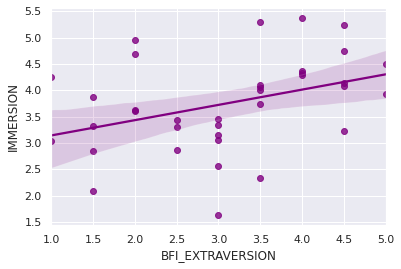

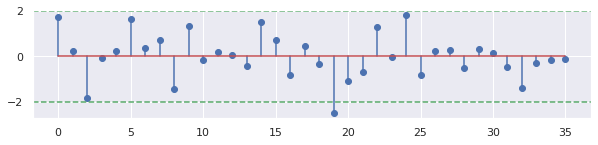

In [48]:
################################################################################ IMMERSION and BFI OPENNESS
res = smf.ols(formula='IMMERSION ~ BFI_EXTRAVERSION', data = e_group).fit()         # Using linear regression, oridnary least square
sns.regplot(x="BFI_EXTRAVERSION", y="IMMERSION", data=e_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

In [49]:
################################################################################# 27. Reader Response and BIG FIVE (TEXT: HARRY; PIPPI, CONDITION:SCRAMBLED)
for reader in ['FOCUSING_OF_ATTENTION','TEXT_ABSORPTION','IMAGINABILITY',
               'SPATIAL_INVOLVEMENT','GENERAL_READING_ENJOYMENT',
               'IDENTIFICATION','EASE_OF_COGNITIVE_ACCESS']:
    e_group = a_group.copy()
    e_group.head()

    bfi_list = []

    for i in range(5):
        bfi_list.append(e_group.columns[i+4])

    def reader_bfi_sa(reader, bfi_list):                                        # Function for the Statistical Analysis
        for i, bfi in enumerate(bfi_list):
            bfi_list = reader +'~ '+ bfi
            res = smf.ols(formula =bfi_list, data = e_group).fit()
            print(bfi)
            print('R2: ', res.rsquared)
            print(res.summary())
            print('')

    reader_bfi_sa(reader, bfi_list)    

BFI_EXTRAVERSION
R2:  0.03892817651143066
                              OLS Regression Results                             
Dep. Variable:     FOCUSING_OF_ATTENTION   R-squared:                       0.039
Model:                               OLS   Adj. R-squared:                  0.011
Method:                    Least Squares   F-statistic:                     1.377
Date:                   Sun, 04 Oct 2020   Prob (F-statistic):              0.249
Time:                           16:23:50   Log-Likelihood:                -61.192
No. Observations:                     36   AIC:                             126.4
Df Residuals:                         34   BIC:                             129.6
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------